In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

# Machine learning libraries
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, precision_score
from sklearn.metrics import roc_curve, auc
from scipy import stats

In [2]:
SavePlots = True

# Import Data

In [3]:
# Import
train_data = pd.read_csv('Data/Exam_2022_Prob4_TrainData.csv')
test_data = pd.read_csv('Data/Exam_2022_Prob4_TestData.csv')
blind_data = pd.read_csv('Data/Exam_2022_Prob4_BlindData.csv')

# See if it looks right
train_data

,ID,Gender,ScheduledDay,AppointmentDay,TimeDifference,Age,Neighbourhood,R1,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,0,0,4,0,2636901,33,43,0,0,0,0,0,0
1,1,0,2,2,562630,33,59,0,0,0,0,1,1
2,2,1,4,0,1440847,53,36,0,0,0,1,1,0
3,3,1,0,0,1766864,0,68,0,0,0,0,0,1
4,4,0,1,1,29819,20,12,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,0,0,0,572986,18,57,0,0,0,0,1,0
19996,19996,1,0,0,50894,55,36,0,0,0,0,0,0
19997,19997,0,2,1,486748,31,68,0,0,0,0,1,0
19998,19998,0,3,2,2298025,50,73,0,0,0,0,1,0


In [4]:
# Define features we will use (in the same order as the data now)
features_to_train = ['Gender',
                    'ScheduledDay',
                    'AppointmentDay',
                    'TimeDifference',
                    'Age',
                    'Neighbourhood',
                    'R1',
                    'Diabetes',
                    'Alcoholism',
                    'Handcap',
                    'SMS_received']

# Problem (4A)

## Explore Data - Comparing Train and Test

In [5]:
print('------ TRAIN SET ------')
# First we lets look at our data - how many of each classes are there?
N_show_train = np.sum( train_data['No-show'] == 0 )
N_noshow_train = np.sum( train_data['No-show'] == 1 )
ratio_train = N_noshow_train / N_show_train

# Print results
print(f'There are {len(train_data)} individuals included in the data set.')
print(f'Number of people who showed: {N_show_train}')
print(f'Number of no-shows: {N_noshow_train}')
print(f'If signal is no-shows, and background people who showed, the signal to noise ratio is: {ratio_train:.2f}')


print('------ TEST SET ------')
# First we lets look at our data - how many of each classes are there?
N_show_test = np.sum( test_data['No-show'] == 0 )
N_noshow_test = np.sum( test_data['No-show'] == 1 )
ratio_test = N_noshow_test / N_show_test

# Print results
print(f'There are {len(test_data)} individuals included in the data set.')
print(f'Number of people who showed: {N_show_test}')
print(f'Number of no-shows: {N_noshow_test}')
print(f'If signal is no-shows, and background people who showed, the signal to noise ratio is: {ratio_test:.2f}')

------ TRAIN SET ------
There are 20000 individuals included in the data set.
Number of people who showed: 15951
Number of no-shows: 4049
If signal is no-shows, and background people who showed, the signal to noise ratio is: 0.25
------ TEST SET ------
There are 20000 individuals included in the data set.
Number of people who showed: 15987
Number of no-shows: 4013
If signal is no-shows, and background people who showed, the signal to noise ratio is: 0.25


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


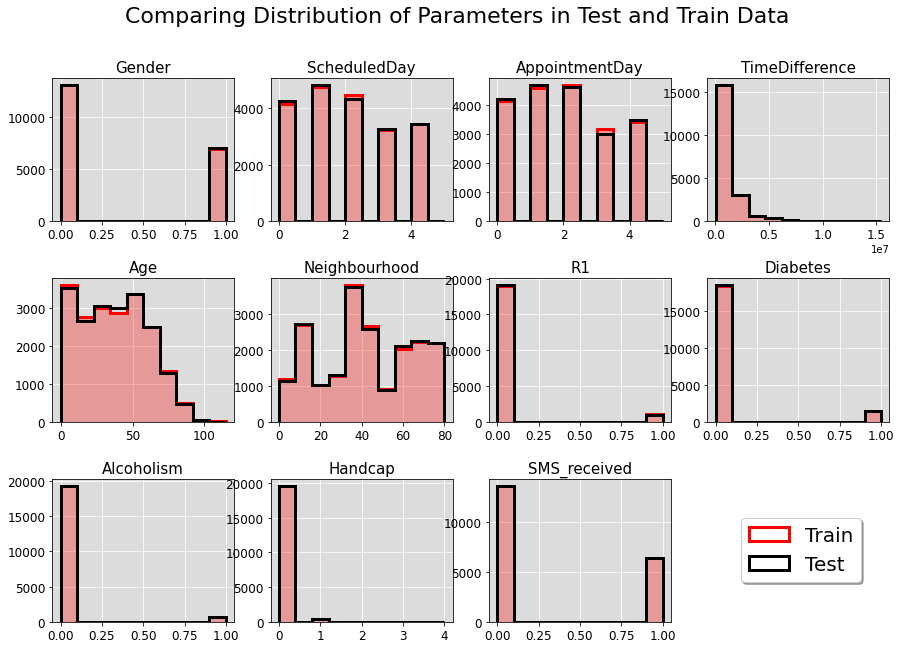

In [6]:
# Show 1D distributions
fig, ax = plt.subplots(nrows=3, ncols=4, gridspec_kw={'wspace':0.2, 'hspace':0.4}, figsize=(15,10))
fig.delaxes(ax[2,3])
ax = ax.flatten()

# Loop over features
for i in range(len(features_to_train)):
    
    ax[i].set_title(features_to_train[i], fontsize=15)
    ax[i].set_facecolor('gainsboro')
    ax[i].grid(color='white')
    ax[i].tick_params(axis="x", labelsize=12) 
    ax[i].tick_params(axis="y", labelsize=12) 
    
    _, bins_arr, _ = ax[i].hist(train_data[features_to_train[i]], bins=10, zorder=2,
                                histtype='step', linewidth=3, color='r', label='Train')
    ax[i].hist(train_data[features_to_train[i]], bins=10, alpha=0.3, linewidth=3, color='r',zorder=2)
    
    ax[i].hist(test_data[features_to_train[i]], bins=bins_arr, zorder=2,
               histtype='step', linewidth=3, color='k', label='Test')
    
ax[10].legend(loc='center right', bbox_to_anchor=(2.1, 0.5), fancybox=True, shadow=True, fontsize=20)

fig.suptitle('Comparing Distribution of Parameters in Test and Train Data', fontsize=22)

if SavePlots:
    plt.tight_layout()
    plt.savefig('Plots/4_1.pdf')

plt.show()

Train and test look pretty similar, nice.

# Split into X and Y -> Prepare for Model

In [7]:
# X contains out parameters - shape (n_samples, n_features)
X_train = train_data[features_to_train]
X_test = test_data[features_to_train]

# Y contains the truth - shape (n_samples)
Y_train = train_data['No-show']
Y_test = test_data['No-show']

# Hyper Parameter Optimization

In [8]:
np.arange(1,10.5,1)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [9]:
np.arange(1, 200.5,20)

array([  1.,  21.,  41.,  61.,  81., 101., 121., 141., 161., 181.])

In [10]:
##### The main parameters are max_depth and n_estimators so lets make a gridsearch of variations those

# Define model
model_temp = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1,
                           learning_rate=0.1, use_label_encoder=False)

# Specify parameters and distributions to sample from
parameters_GridSearch = {'max_depth': [1,2,4,6,8,10], 
                         'n_estimators': [25,50,75,100,125,150]}

# Chose number of iterations and number of folds
k = 5

GridSearch = GridSearchCV(model_temp, 
                          param_grid=parameters_GridSearch, 
                          cv=k, 
                          return_train_score=True,
                          scoring = 'accuracy')

# Fit the random search instance
GridSearch.fit(X_train, Y_train);

# Get results
GridSearch_results = pd.DataFrame(GridSearch.cv_results_)                 
print("Grid Search: \tBest parameters: ", GridSearch.best_params_, f", Best scores: {GridSearch.best_score_:.3f}")

GridSearch_results.head(3)

Grid Search: 	Best parameters:  {'max_depth': 4, 'n_estimators': 75} , Best scores: 0.818


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.141065,0.125529,0.003388,0.000671,1,25,"{'max_depth': 1, 'n_estimators': 25}",0.82250,0.81450,0.819,...,0.81715,0.003308,9,0.815813,0.817813,0.816813,0.818125,0.817312,0.817175,0.000814
1,0.218255,0.106389,0.004316,0.001504,1,50,"{'max_depth': 1, 'n_estimators': 50}",0.82275,0.81425,0.819,...,0.81715,0.003430,9,0.815813,0.818000,0.816813,0.818250,0.817375,0.817250,0.000876
2,0.298626,0.075786,0.004097,0.000916,1,75,"{'max_depth': 1, 'n_estimators': 75}",0.82275,0.81425,0.819,...,0.81715,0.003430,9,0.815813,0.818000,0.816813,0.818250,0.817375,0.817250,0.000876


In [11]:
# Grid Search 2 - zoomed grid close to best value #

# Specify parameters and distributions to sample from
parameters_GridSearch2 = {'max_depth': [2,3,4,5,6], 
                         'n_estimators': [50,60,70,80,90,100]}

# Chose number of iterations and number of folds
k = 5

GridSearch2 = GridSearchCV(model_temp, 
                           param_grid=parameters_GridSearch2, 
                           cv=k, 
                           return_train_score=True,
                           scoring = 'accuracy')

# Fit the random search instance
GridSearch2.fit(X_train, Y_train);

# Get results
GridSearch2_results = pd.DataFrame(GridSearch2.cv_results_)                 
print("Grid Search: \tBest parameters: ", GridSearch2.best_params_, f", Best scores: {GridSearch2.best_score_:.3f}")

GridSearch2_results.head(3)

Grid Search: 	Best parameters:  {'max_depth': 4, 'n_estimators': 80} , Best scores: 0.818


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.310863,0.145391,0.004188,0.001948,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.823,0.81425,0.81925,...,0.81710,0.003717,17,0.815937,0.818063,0.816875,0.818688,0.817375,0.817388,0.000950
1,0.230549,0.004153,0.003458,0.000425,2,60,"{'max_depth': 2, 'n_estimators': 60}",0.823,0.81425,0.81925,...,0.81710,0.003717,17,0.815875,0.818125,0.816875,0.818562,0.817375,0.817362,0.000946
2,0.276635,0.012323,0.003528,0.000663,2,70,"{'max_depth': 2, 'n_estimators': 70}",0.823,0.81450,0.81925,...,0.81715,0.003680,15,0.815875,0.818063,0.817000,0.818562,0.817438,0.817388,0.000925


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


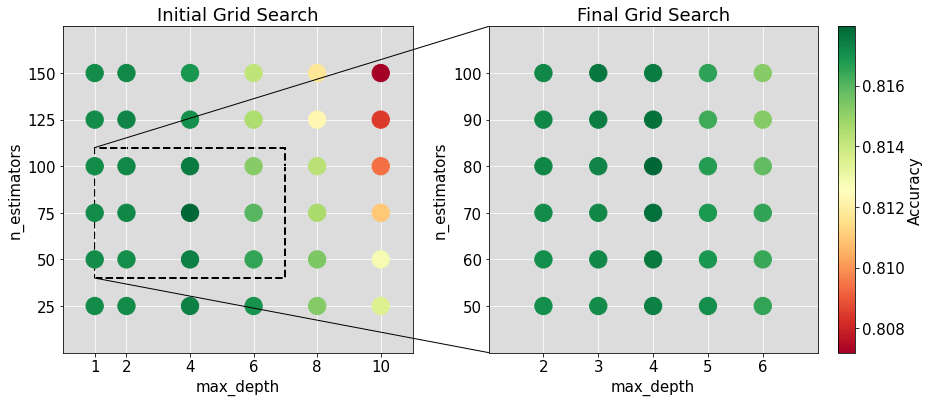

In [12]:
# Lets try to plot it with colors in a 2d parameter space ----------------------------------

# Create figure
fig, ax = plt.subplots(ncols=2, figsize=(15,6), gridspec_kw={'wspace':0.2, 'width_ratios':(1.7,2)})

# Get parameters
x1 = GridSearch_results['param_max_depth']
x2 = GridSearch_results['param_n_estimators']
color = GridSearch_results['mean_test_score']

x1_2 = GridSearch2_results['param_max_depth']
x2_2 = GridSearch2_results['param_n_estimators']
color2 = GridSearch2_results['mean_test_score']

mini, maxi = np.min(np.concatenate((color,color2))), np.max(np.concatenate((color,color2))) #color ranges


# Plot initial random search
ax[0].scatter(x1, x2, s=300, c = color, cmap='RdYlGn', zorder=2)#, vmin=mini, vmax=maxi)
ax[0].set_facecolor('gainsboro')
ax[0].grid(color='w')
ax[0].set_xlabel('max_depth', fontsize=15)
ax[0].set_ylabel('n_estimators', fontsize=15)
ax[0].set_title('Initial Grid Search', fontsize=18)

ax[0].set_xlim(0,11)
ax[0].set_ylim(0,175)

ax[0].set_xticks([1,2,4,6,8,10])
ax[0].set_yticks([25,50,75,100,125,150])

ax[0].tick_params(axis="x", labelsize=15) 
ax[0].tick_params(axis="y", labelsize=15)


# Plot final search
im2 = ax[1].scatter(x1_2, x2_2, s=300, c = color2, cmap='RdYlGn', zorder=2, vmin=mini, vmax=maxi)
ax[1].set_facecolor('gainsboro')
ax[1].grid(color='w')
ax[1].set_xlabel('max_depth', fontsize=15)
ax[1].set_ylabel('n_estimators', fontsize=15)
ax[1].set_title('Final Grid Search', fontsize=18)

ax[1].set_xlim(1,7)
ax[1].set_ylim(40,110)

ax[1].set_xticks([2,3,4,5,6])
ax[1].set_yticks([50,60,70,80,90,100])

ax[1].tick_params(axis="x", labelsize=15) 
ax[1].tick_params(axis="y", labelsize=15)


# Shared colorbar
cbar = fig.colorbar(im2, ax=ax[1])
cbar.set_label('Accuracy', fontsize=15, x=1.7)
cbar.ax.tick_params(labelsize=15)


# Mark the zoom in plot ------------------------
xlim2 = (1,7)
ylim2 = (40,110)

# Square (x,y,width,height)
rect = patches.Rectangle((xlim2[0],ylim2[0]), xlim2[1]-xlim2[0], ylim2[1]-ylim2[0], linewidth=2, edgecolor='k', facecolor='none', linestyle='dashed')
ax[0].add_patch(rect)
# Lines
line1 = patches.ConnectionPatch(xyA=(xlim2[0],ylim2[1]), xyB=(xlim2[0],ylim2[1]), coordsA=ax[0].transData, coordsB=ax[1].transData)
fig.add_artist(line1)
line2 = patches.ConnectionPatch(xyA=(xlim2[0],ylim2[0]), xyB=(xlim2[0],ylim2[0]), coordsA=ax[0].transData, coordsB=ax[1].transData)
fig.add_artist(line2)

if SavePlots:
    plt.tight_layout()
    plt.savefig('Plots/4_2.pdf')
    
plt.show()

In [13]:
# Set the hyperparameters found
max_depth_GS = GridSearch2.best_params_['max_depth']
n_estimators_GS = GridSearch2.best_params_['n_estimators']
print('We use max depth:', max_depth_GS, 'and n_estimators:', n_estimators_GS)

We use max depth: 4 and n_estimators: 80


# Classifier

In [14]:
# Define model
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1,
                      learning_rate=0.1, use_label_encoder=False, n_estimators=n_estimators_GS, 
                      max_depth=max_depth_GS)

# Train model
model.fit(X_train, Y_train)

# Calculate accuracy on train
Y_pred_train = model.predict(X_train)
accuracy_train = accuracy_score(Y_train, Y_pred_train)
print('Accuracy on Train:', accuracy_train)

# Calculate accuracy on test
Y_pred_test = model.predict(X_test)
accuracy_test = accuracy_score(Y_test, Y_pred_test)
print('Accuracy on Test:', accuracy_test)

# Get predictions
# a numpy array of shape array-like of shape (n_samples, n_classes) 
# with the probability of each data example being of a given class.

# Train
predictions_train = model.predict_proba(X_train) 
predictions_train = pd.DataFrame(predictions_train, columns=['Show', 'No-show'])

# Test
predictions_test = model.predict_proba(X_test) 
predictions_test = pd.DataFrame(predictions_test, columns=['Show', 'No-show'])

Accuracy on Train: 0.82065
Accuracy on Test: 0.81545


## ROC curve

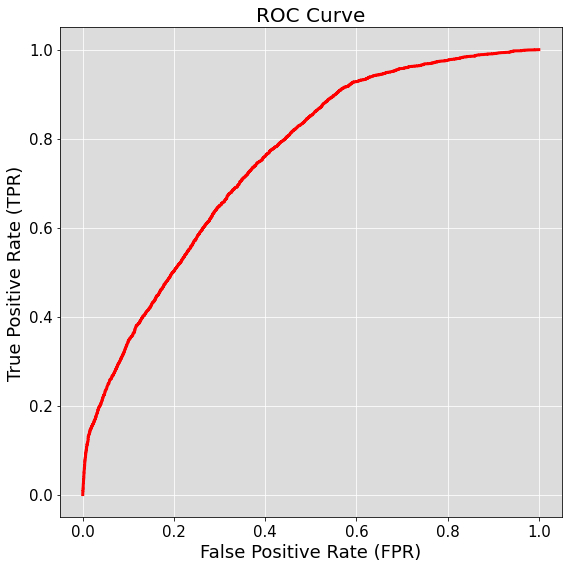

In [15]:
# Get fpr and tpr to produce roc_curve
fpr, tpr, _ = roc_curve(Y_test, predictions_test['No-show'])
auc_score = auc(fpr, tpr)

# Plot it
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(fpr, tpr, color='r', linewidth=3)

ax.set_facecolor('gainsboro')
ax.grid(color='white')

ax.set_xlabel('False Positive Rate (FPR)', fontsize=18)
ax.set_ylabel('True Positive Rate (TPR)', fontsize=18)
ax.set_title('ROC Curve', fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.savefig('Plots/4_roc.pdf')

plt.show()

# 4A Solution Plot

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


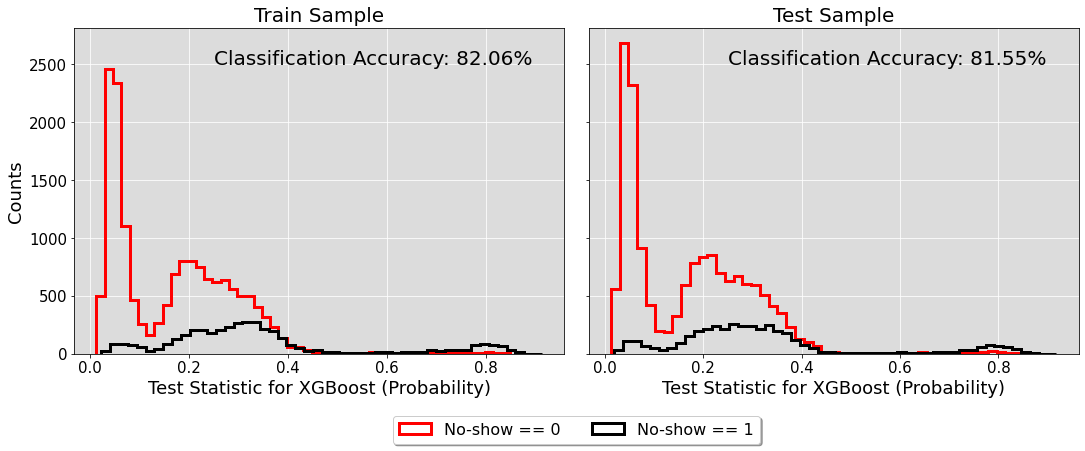

In [16]:
# Create test statistic plot
fig, ax = plt.subplots(ncols=2, figsize=(18,6), sharey=True, gridspec_kw={'wspace':0.05})

# Train sample ---------
ax[0].hist(predictions_train['No-show'][Y_train==0], color='r', histtype='step', 
           bins=50, linewidth=3, label='No-show == 0')
ax[0].hist(predictions_train['No-show'][Y_train==1], color='k', histtype='step', 
           bins=50, linewidth=3, label='No-show == 1')

# Write accuracy
ax[0].text(0.25, 2500, f'Classification Accuracy: {accuracy_train*100:.2f}%', fontsize=20)

ax[0].tick_params(axis="x", labelsize=15) 
ax[0].tick_params(axis="y", labelsize=15) 
ax[0].set_ylabel('Counts', fontsize=18)
ax[0].set_xlabel('Test Statistic for XGBoost (Probability)', fontsize=18)
ax[0].set_title('Train Sample', fontsize=20)

ax[0].set_facecolor('gainsboro')
ax[0].grid(color='white')

# Test sample ---------
ax[1].hist(predictions_test['No-show'][Y_test==0], color='r', histtype='step', 
           bins=50, linewidth=3, label='No-show == 0')
ax[1].hist(predictions_test['No-show'][Y_test==1], color='k', histtype='step', 
           bins=50, linewidth=3, label='No-show == 1')

# Write accuracy
ax[1].text(0.25, 2500, f'Classification Accuracy: {accuracy_test*100:.2f}%', fontsize=20)

ax[1].set_facecolor('gainsboro')
ax[1].grid(color='white')


# Pretty
ax[1].legend(loc='lower center', prop={'size':16}, bbox_to_anchor=(-0.025, -0.3),
          ncol=3, fancybox=True, shadow=True)

ax[1].tick_params(axis="x", labelsize=15) 
ax[1].set_xlabel('Test Statistic for XGBoost (Probability)', fontsize=18)
ax[1].set_title('Test Sample', fontsize=20)

if SavePlots:
    plt.tight_layout()
    plt.savefig('Plots/4_3.pdf')

plt.show()

## Can the accuracy become better when adjusting the cut?

In [17]:
# Define function to compute accuracy for different cuts
def compute_accuracy(prob_noshow_arr, cut, true_labels):
    
    # Array to put classifications in, all start as low earner
    pred = np.zeros(len(prob_noshow_arr))
    
    # Make a mask saying when the probability is above the cut and it should be classified as high earner
    noshow_mask = (prob_noshow_arr > cut)
    
    # Make classifications
    pred[noshow_mask] = 1
    
    # Return the precision
    return accuracy_score(y_true=true_labels, y_pred=pred)

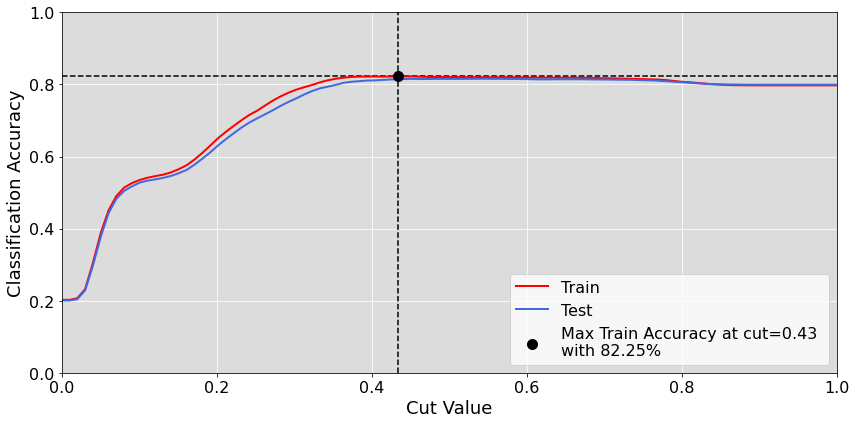

In [18]:
# Different values to test of cut
cut_arr = np.linspace(0,1,100)

# Array to store precision
accuracy_arr = np.zeros(100)
accuracy_arr_test = np.zeros(100)

for i in range(len(cut_arr)):
    
    accuracy_arr[i] = compute_accuracy(predictions_train['No-show'], cut_arr[i], Y_train)
    accuracy_arr_test[i] = compute_accuracy(predictions_test['No-show'], cut_arr[i], Y_test)
    
# Chose best accuracy
idx_cut = np.argmax(accuracy_arr)

# Plot choice of cut
fig, ax = plt.subplots(figsize=(12,6))

ax.set_facecolor('gainsboro')
ax.grid(color='white')

ax.plot(cut_arr, accuracy_arr, color='r', linewidth=2, label='Train')
ax.plot(cut_arr, accuracy_arr_test, color='royalblue', linewidth=2, label='Test')

ax.scatter(cut_arr[idx_cut], accuracy_arr[idx_cut], color='k', s=100, zorder=3,
           label=f'Max Train Accuracy at cut={cut_arr[idx_cut]:.2f} \nwith {accuracy_arr[idx_cut]*100:.2f}%')
ax.hlines(accuracy_arr[idx_cut], 0, 1, linestyle='dashed', color='k')
ax.vlines(cut_arr[idx_cut], 0, 1, linestyle='dashed', color='k')

ax.legend(prop={'size':16}, loc='lower right')

plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xlabel('Cut Value', fontsize=18)
ax.set_ylabel('Classification Accuracy', fontsize=18)

if SavePlots:
    plt.tight_layout()
    plt.savefig('Plots/4_4.pdf')

plt.show()

In [19]:
# Calculate the accuracy on the test set with the given cut
accuracy_test = compute_accuracy(predictions_test['No-show'], cut_arr[idx_cut], Y_test)
accuracy_test

0.81465

not better, big sad

# Problem (4B)

In [20]:
model.feature_importances_

array([0.02748342, 0.04755081, 0.0346735 , 0.17927186, 0.05610883,
       0.03245685, 0.48386505, 0.01832965, 0.03573309, 0.0400703 ,
       0.04445668], dtype=float32)

In [35]:
np.sort(model.feature_importances_)

array([0.01832965, 0.02748342, 0.03245685, 0.0346735 , 0.03573309,
       0.0400703 , 0.04445668, 0.04755081, 0.05610883, 0.17927186,
       0.48386505], dtype=float32)

In [32]:
print(features_to_train[6],
features_to_train[3],
features_to_train[4],
features_to_train[1],
features_to_train[10],
features_to_train[9], features_to_train[8], features_to_train[2], 
features_to_train[5], features_to_train[0], features_to_train[7])
      

R1 TimeDifference Age ScheduledDay SMS_received Handcap Alcoholism AppointmentDay Neighbourhood Gender Diabetes


In [23]:
features_to_train

['Gender',
 'ScheduledDay',
 'AppointmentDay',
 'TimeDifference',
 'Age',
 'Neighbourhood',
 'R1',
 'Diabetes',
 'Alcoholism',
 'Handcap',
 'SMS_received']

## Repeat the same, but only with best 6 features now

In [33]:
## Same model as before, but lets remove some of the worst features
best_features = ['R1', 'TimeDifference', 'Age', 'ScheduledDay', 'SMS_received' ]
#best_features = ['Age','SMS_received']

# X contains out parameters - shape (n_samples, n_features)
X2_train = train_data[best_features]
X2_test = test_data[best_features]

# Y contains the truth - shape (n_samples)
Y2_train = train_data['No-show']
Y2_test = test_data['No-show']

In [34]:
# Define model
model2 = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1,
                      learning_rate=0.1, use_label_encoder=False, n_estimators=n_estimators_GS, 
                      max_depth=max_depth_GS)

# Train model
model2.fit(X2_train, Y2_train)

# Calculate accuracy on train
Y2_pred_train = model2.predict(X2_train)
accuracy2_train = accuracy_score(Y2_train, Y2_pred_train)
print('Accuracy on Train:', accuracy2_train)

# Calculate accuracy on test
Y2_pred_test = model2.predict(X2_test)
accuracy2_test = accuracy_score(Y2_test, Y2_pred_test)
print('Accuracy on Test:', accuracy_test)

# Get predictions
# a numpy array of shape array-like of shape (n_samples, n_classes) 
# with the probability of each data example being of a given class.

# Train
predictions2_train = model2.predict_proba(X2_train) 
predictions2_train = pd.DataFrame(predictions2_train, columns=['Show', 'No-show'])

# Test
predictions2_test = model2.predict_proba(X2_test) 
predictions2_test = pd.DataFrame(predictions2_test, columns=['Show', 'No-show'])

Accuracy on Train: 0.8205
Accuracy on Test: 0.81465


it did not get better :(

# Problem (4C)

In [26]:
# Extract only the parameters to make X_val (n_samples, n_parameters)
X_blind = blind_data[features_to_train] #removes ID column

# Extract ID's for good measure
ID_blind = blind_data['ID']

# Make predictions
predictions_blind = model.predict(X_blind) 
predictions_blind

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
# Check how many there are of each
print(f'Model found {np.sum(predictions_blind)} no-shows == 1')
print(f'Model found {len(predictions_blind)-np.sum(predictions_blind)} no-shows == 0')

print(f'Len of real data: {len(predictions_blind)}')

Model found 798 no-shows == 1
Model found 19202 no-shows == 0
Len of real data: 20000


In [28]:
len(ID_blind[predictions_blind == 1])

798

In [29]:
# Create the output file for no-show == 1
with open('Data/Kreilgaard.AMAS_Exam.Problem4.NoShowTrue.txt', 'w') as f:
    for line in ID_blind[predictions_blind == 1]:
        line = str(line)
        f.write(line)
        f.write('\n')
        
# Create the output file for no-show == 0
with open('Data/Kreilgaard.AMAS_Exam.Problem4.NoShowFalse.txt', 'w') as f:
    for line in ID_blind[predictions_blind == 0]:
        line = str(line)
        f.write(line)
        f.write('\n')